In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_hub as hub
%matplotlib inline

##Download and convert the ESRGAN model

In [4]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

In [5]:
concrete_func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1,50,50,3])  # 1 image of size 100,100,3
converter=tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model=converter.convert()

In [6]:
# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite' 

In [7]:
#Download a test image (insect head).
test_img_path=tf.keras.utils.get_file('lr.jpg', 'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')

8192/6432 [======================================] - 0s 0us/step


##Generate a super resolution image using TensorFlow Lite

In [21]:
import numpy as np

lr=cv2.imread(test_img_path)
lr=tf.convert_to_tensor(lr)
#print(lr.shape)
#lr=cv2.cvtColor(lr,cv2.COLOR_BGR2GRAY)
#lr = tf.image.decode_jpeg(lr, channels=3)
#lr=np.resize(lr,[*im_size,3])

lr=tf.expand_dims(lr,0)
print(lr.shape)
lr=tf.cast(lr,tf.float32)


# Load TFLite model and allocate tensors.

interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()
# Get input and output tensors.
in_tensor=interpreter.get_input_details()
out_tensor=interpreter.get_output_details()

# Run the model
interpreter.set_tensor(in_tensor[0]['index'],lr)
interpreter.invoke()
# Extract the output and postprocess it

output_data=interpreter.get_tensor(out_tensor[0]['index'])
sr=tf.squeeze(output_data,axis=0)
sr=tf.clip_by_value(sr,0,255)
sr=tf.round(sr)
sr=tf.cast(sr,tf.uint8)

(1, 50, 50, 3)


##Visualize the result

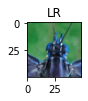

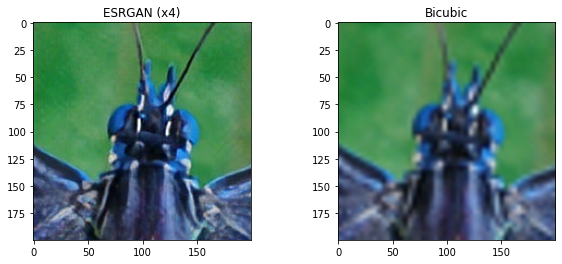

In [22]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());